Let's take a look at the cyclicality of electricity markets. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import datetime as dt
import scipy.io

Data from http://www.ieso.ca/power-data

In [2]:
new_price = pd.read_csv('data/HOEP.csv')
price = pd.read_csv('data/HOEP_2002-2017.csv')
price = price.append(new_price, ignore_index=True)

new_demand = pd.read_csv('data/HourlyDemands.csv')
demand = pd.read_csv('data/HourlyDemands_2002-2017.csv')
demand = demand.append(new_demand, ignore_index=True)

The datasets are a little bit big, so we'll parallelize some operations to make them faster.

In [3]:
from multiprocessing import cpu_count, Pool
num_partitions = 16
num_cores = 8

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def to_datetime(x: pd.DataFrame) -> pd.DataFrame:
    x['Date'] = pd.to_datetime(x['Date'], format='%d-%b-%y')
    return x

In [4]:
demand.head()

,Date,Hour,Total Market Demand,Ontario Demand
0,01-May-02,1,14141,14137
1,01-May-02,2,13876,13872
2,01-May-02,3,13974,13820
3,01-May-02,4,13898,13744
4,01-May-02,5,14378,14224


First, let's resample our data into monthly averages to look for any long term trends.

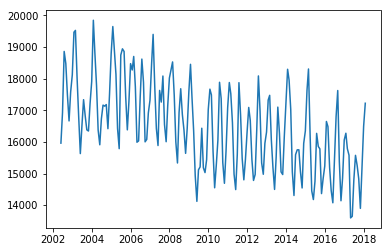

In [5]:
df = demand.copy(deep=True)
df.drop(['Total Market Demand', 'Hour'], axis=1, inplace=True)
df = parallelize_dataframe(df, to_datetime)
df.set_index('Date', drop=True, inplace=True)
df = df.resample('M').mean()
plt.plot(df)
plt.show()

There's definitely a long term downward trend, but the real story is the cyclically and volatility. Let's take a closer look at that.

Let's pivot our data into hourly columns, and save it as a .mat file for a Octave/Matlab waterfall plot.

In [6]:
df = demand.copy(deep=True)
df = parallelize_dataframe(df, to_datetime)
df = df.pivot(index='Date', columns='Hour', values='Ontario Demand')

In [7]:
dates = df.index.strftime("%Y-%m-%d")

scipy.io.savemat('data/z_values.mat', {'mdict': df.values})
scipy.io.savemat('data/x_values.mat', {'mdict': dates})

Now that we've seen the interesting price variations, let's examine the difference between summer and winter months more closely.

In [8]:
df = demand.copy(deep=True)
df = parallelize_dataframe(df, to_datetime)
df = df.pivot(index='Date', columns='Hour', values='Ontario Demand')
# The warmest months in Toronto are June, July, and August, so we use [6,7,8]
summer = df[df.index.month.isin([6, 7, 8])].mean()
# The coldest months are January, Febuary, and December, so we use [1, 2, 12]
winter = df[df.index.month.isin([1, 2, 12])].mean()

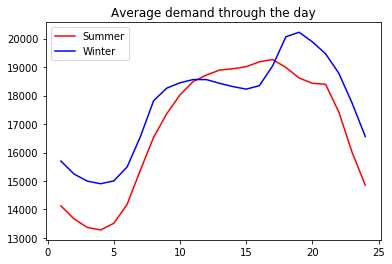

In [9]:
plt.plot(summer, 'r', label='Summer')
plt.plot(winter, 'b', label='Winter')
plt.title('Average demand through the day')
plt.legend()
plt.show()

As we can see, average summer demand peaks around 3 or 4pm, probably due to air conditioning, while winter demand has an interesting trough mid-day probably due to reduced need for heating while the sun is strongest.

Let's also save our pivoted price data for further analysis.

In [10]:
df = price.copy(deep=True)
df = parallelize_dataframe(df, to_datetime)
df = df.pivot(index='Date', columns='Hour', values='HOEP')

In [11]:
dates = df.index.strftime("%Y-%m-%d")

scipy.io.savemat('data/price_z_values.mat', {'mdict': df.values})
scipy.io.savemat('data/price_x_values.mat', {'mdict': dates})